In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scienceplots
import torch
import sys
from options import parse_option

mpl.rcParams['figure.dpi'] = 200
plt.style.use(['science'])

In [89]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_selfattention(transformer_encoder,x,mask,src_key_padding_mask,i_layer,d_model,num_heads):
    h = F.linear(x, transformer_encoder.layers[i_layer].self_attn.in_proj_weight, bias=transformer_encoder.layers[i_layer].self_attn.in_proj_bias)
    qkv = h.reshape(x.shape[0], x.shape[1], num_heads, 3 * d_model//num_heads)
    qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
    q, k, v = qkv.chunk(3, dim=-1) # [Batch, Head, SeqLen, d_head=d_model//num_heads]
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) # [Batch, Head, SeqLen, SeqLen]
    d_k = q.size()[-1]
    attn_probs = attn_logits / math.sqrt(d_k)
    # combining src_mask e.g. upper triangular with src_key_padding_mask e.g. columns over each padding position
    combined_mask = torch.zeros_like(attn_probs)
    if mask is not None:
        combined_mask += mask.float() # assume mask of shape (seq_len,seq_len)
    if src_key_padding_mask is not None:
        combined_mask += src_key_padding_mask.float().unsqueeze(1).unsqueeze(1).repeat(1,num_heads,x.shape[1],1)
        # assume shape (batch_size,seq_len), repeating along head and line dimensions == "column" mask
    combined_mask = torch.where(combined_mask>0,torch.zeros_like(combined_mask)-float("inf"),torch.zeros_like(combined_mask))
    # setting masked logits to -inf before softmax
    attn_probs += combined_mask
    attn_probs = F.softmax(attn_probs, dim=-1)
    return attn_logits,attn_probs

def extract_selfattention_maps(transformer_encoder,x,mask,src_key_padding_mask):
    attn_logits_maps = []
    attn_probs_maps = []
    num_layers = transformer_encoder.num_layers
    d_model = transformer_encoder.layers[0].self_attn.embed_dim
    num_heads = transformer_encoder.layers[0].self_attn.num_heads
    norm_first = transformer_encoder.layers[0].norm_first
    with torch.no_grad():
        for i in range(num_layers):
            # compute attention of layer i
            h = x.clone()
            if norm_first:
                h = transformer_encoder.layers[i].norm1(h)
            # attn = transformer_encoder.layers[i].self_attn(h, h, h,attn_mask=mask,key_padding_mask=src_key_padding_mask,need_weights=True)[1]
            # attention_maps.append(attn) # of shape [batch_size,seq_len,seq_len]
            attn_logits,attn_probs = compute_selfattention(transformer_encoder,h,mask,src_key_padding_mask,i,d_model,num_heads)
            attn_logits_maps.append(attn_logits) # of shape [batch_size,num_heads,seq_len,seq_len]
            attn_probs_maps.append(attn_probs)
            # forward of layer i
            x = transformer_encoder.layers[i](x,src_mask=mask,src_key_padding_mask=src_key_padding_mask)
    return attn_logits_maps,attn_probs_maps




In [90]:
from model import TransformerModel
model_path = 'best_model_counting_nlayers4'
ntokens = 2
d_model = 16
nheads = 2
emsize = 16
nlayers = 4
model = TransformerModel(
    ntokens, d_model, nheads, emsize, nlayers, 2, 0.2
)

state_dict = torch.load(model_path,map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

transformer_encoder = model.transformer_encoder
embedding = model.embedding

In [95]:
batch_size = 3
seq_len = 16 

#x = torch.randn((batch_size,seq_len,d_model))
binary_sequence = torch.randint(0,2, (batch_size,seq_len,1))
print(binary_sequence.shape)
x = embedding(binary_sequence).squeeze()
print(x.shape)

src_mask = torch.zeros((seq_len,seq_len)).bool()
# src_mask can also be of shape (N⋅num_heads,L,S) where L/S are the target/source sequence lengths
# -> allows different masking per element in the batch
src_key_padding_mask = torch.zeros((batch_size,seq_len)).bool()

attn_logits_maps,attn_probs_maps = extract_selfattention_maps(transformer_encoder,x,src_mask,src_key_padding_mask)

torch.Size([3, 16, 1])
torch.Size([3, 16, 16])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._transformer_encoder_layer_fwd(


tensor([[0.0714, 0.0556, 0.0714, 0.0714, 0.0556, 0.0714, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0714, 0.0556, 0.0714, 0.0556, 0.0714, 0.0556],
        [0.0683, 0.0580, 0.0683, 0.0683, 0.0580, 0.0683, 0.0580, 0.0580, 0.0580,
         0.0580, 0.0683, 0.0580, 0.0683, 0.0580, 0.0683, 0.0580],
        [0.0714, 0.0556, 0.0714, 0.0714, 0.0556, 0.0714, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0714, 0.0556, 0.0714, 0.0556, 0.0714, 0.0556],
        [0.0714, 0.0556, 0.0714, 0.0714, 0.0556, 0.0714, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0714, 0.0556, 0.0714, 0.0556, 0.0714, 0.0556],
        [0.0683, 0.0580, 0.0683, 0.0683, 0.0580, 0.0683, 0.0580, 0.0580, 0.0580,
         0.0580, 0.0683, 0.0580, 0.0683, 0.0580, 0.0683, 0.0580],
        [0.0714, 0.0556, 0.0714, 0.0714, 0.0556, 0.0714, 0.0556, 0.0556, 0.0556,
         0.0556, 0.0714, 0.0556, 0.0714, 0.0556, 0.0714, 0.0556],
        [0.0683, 0.0580, 0.0683, 0.0683, 0.0580, 0.0683, 0.0580, 0.0580, 0.0580,
         0.0580, 0.0683, 0.0580, 0.06

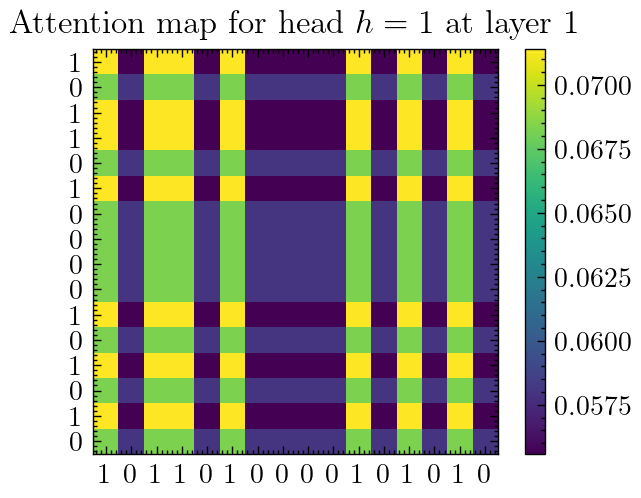

tensor([[0.0631, 0.0621, 0.0631, 0.0631, 0.0621, 0.0631, 0.0621, 0.0621, 0.0621,
         0.0621, 0.0631, 0.0621, 0.0631, 0.0621, 0.0631, 0.0621],
        [0.0618, 0.0631, 0.0618, 0.0618, 0.0631, 0.0618, 0.0631, 0.0631, 0.0631,
         0.0631, 0.0618, 0.0631, 0.0618, 0.0631, 0.0618, 0.0631],
        [0.0631, 0.0621, 0.0631, 0.0631, 0.0621, 0.0631, 0.0621, 0.0621, 0.0621,
         0.0621, 0.0631, 0.0621, 0.0631, 0.0621, 0.0631, 0.0621],
        [0.0631, 0.0621, 0.0631, 0.0631, 0.0621, 0.0631, 0.0621, 0.0621, 0.0621,
         0.0621, 0.0631, 0.0621, 0.0631, 0.0621, 0.0631, 0.0621],
        [0.0618, 0.0631, 0.0618, 0.0618, 0.0631, 0.0618, 0.0631, 0.0631, 0.0631,
         0.0631, 0.0618, 0.0631, 0.0618, 0.0631, 0.0618, 0.0631],
        [0.0631, 0.0621, 0.0631, 0.0631, 0.0621, 0.0631, 0.0621, 0.0621, 0.0621,
         0.0621, 0.0631, 0.0621, 0.0631, 0.0621, 0.0631, 0.0621],
        [0.0618, 0.0631, 0.0618, 0.0618, 0.0631, 0.0618, 0.0631, 0.0631, 0.0631,
         0.0631, 0.0618, 0.0631, 0.06

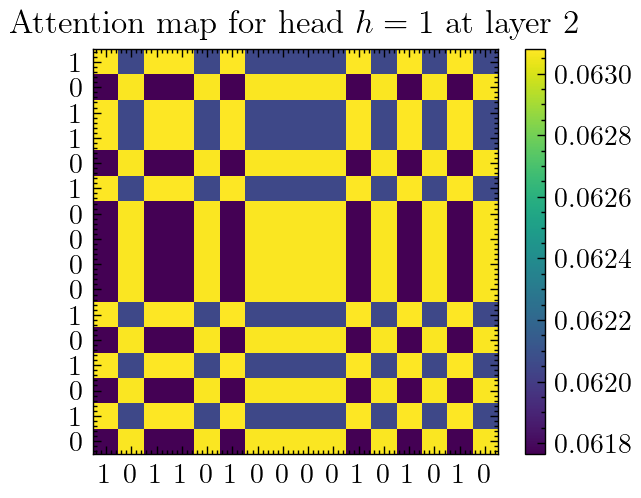

tensor([[0.1018, 0.0319, 0.1018, 0.1018, 0.0319, 0.1018, 0.0319, 0.0319, 0.0319,
         0.0319, 0.1018, 0.0319, 0.1018, 0.0319, 0.1018, 0.0319],
        [0.0999, 0.0334, 0.0999, 0.0999, 0.0334, 0.0999, 0.0334, 0.0334, 0.0334,
         0.0334, 0.0999, 0.0334, 0.0999, 0.0334, 0.0999, 0.0334],
        [0.1018, 0.0319, 0.1018, 0.1018, 0.0319, 0.1018, 0.0319, 0.0319, 0.0319,
         0.0319, 0.1018, 0.0319, 0.1018, 0.0319, 0.1018, 0.0319],
        [0.1018, 0.0319, 0.1018, 0.1018, 0.0319, 0.1018, 0.0319, 0.0319, 0.0319,
         0.0319, 0.1018, 0.0319, 0.1018, 0.0319, 0.1018, 0.0319],
        [0.0999, 0.0334, 0.0999, 0.0999, 0.0334, 0.0999, 0.0334, 0.0334, 0.0334,
         0.0334, 0.0999, 0.0334, 0.0999, 0.0334, 0.0999, 0.0334],
        [0.1018, 0.0319, 0.1018, 0.1018, 0.0319, 0.1018, 0.0319, 0.0319, 0.0319,
         0.0319, 0.1018, 0.0319, 0.1018, 0.0319, 0.1018, 0.0319],
        [0.0999, 0.0334, 0.0999, 0.0999, 0.0334, 0.0999, 0.0334, 0.0334, 0.0334,
         0.0334, 0.0999, 0.0334, 0.09

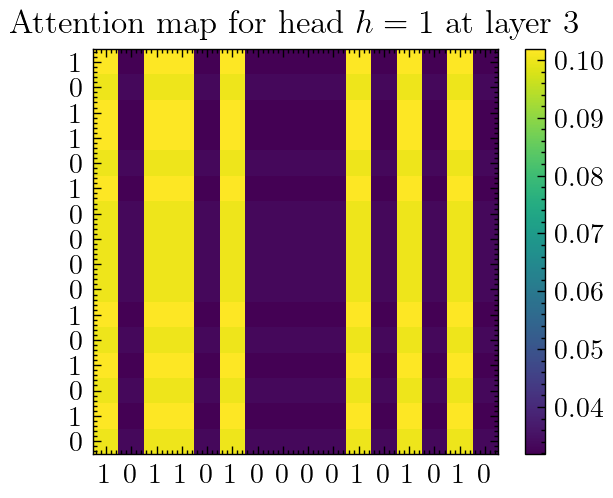

tensor([[0.0883, 0.0425, 0.0883, 0.0883, 0.0425, 0.0883, 0.0425, 0.0425, 0.0425,
         0.0425, 0.0883, 0.0425, 0.0883, 0.0425, 0.0883, 0.0425],
        [0.0994, 0.0338, 0.0994, 0.0994, 0.0338, 0.0994, 0.0338, 0.0338, 0.0338,
         0.0338, 0.0994, 0.0338, 0.0994, 0.0338, 0.0994, 0.0338],
        [0.0883, 0.0425, 0.0883, 0.0883, 0.0425, 0.0883, 0.0425, 0.0425, 0.0425,
         0.0425, 0.0883, 0.0425, 0.0883, 0.0425, 0.0883, 0.0425],
        [0.0883, 0.0425, 0.0883, 0.0883, 0.0425, 0.0883, 0.0425, 0.0425, 0.0425,
         0.0425, 0.0883, 0.0425, 0.0883, 0.0425, 0.0883, 0.0425],
        [0.0994, 0.0338, 0.0994, 0.0994, 0.0338, 0.0994, 0.0338, 0.0338, 0.0338,
         0.0338, 0.0994, 0.0338, 0.0994, 0.0338, 0.0994, 0.0338],
        [0.0883, 0.0425, 0.0883, 0.0883, 0.0425, 0.0883, 0.0425, 0.0425, 0.0425,
         0.0425, 0.0883, 0.0425, 0.0883, 0.0425, 0.0883, 0.0425],
        [0.0994, 0.0338, 0.0994, 0.0994, 0.0338, 0.0994, 0.0338, 0.0338, 0.0338,
         0.0338, 0.0994, 0.0338, 0.09

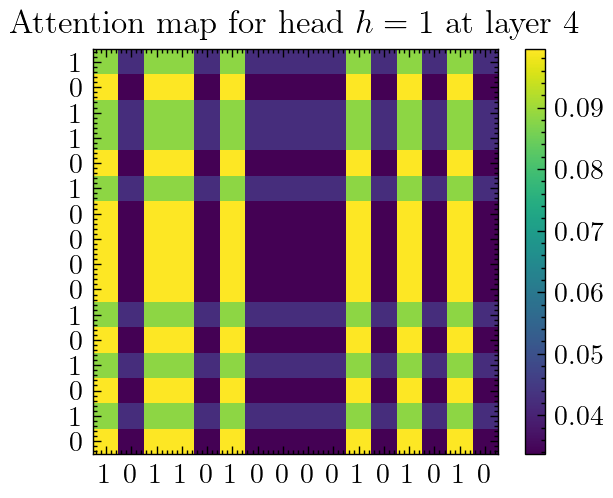

tensor([[0.0701, 0.0566, 0.0701, 0.0701, 0.0566, 0.0701, 0.0566, 0.0566, 0.0566,
         0.0566, 0.0701, 0.0566, 0.0701, 0.0566, 0.0701, 0.0566],
        [0.0534, 0.0696, 0.0534, 0.0534, 0.0696, 0.0534, 0.0696, 0.0696, 0.0696,
         0.0696, 0.0534, 0.0696, 0.0534, 0.0696, 0.0534, 0.0696],
        [0.0701, 0.0566, 0.0701, 0.0701, 0.0566, 0.0701, 0.0566, 0.0566, 0.0566,
         0.0566, 0.0701, 0.0566, 0.0701, 0.0566, 0.0701, 0.0566],
        [0.0701, 0.0566, 0.0701, 0.0701, 0.0566, 0.0701, 0.0566, 0.0566, 0.0566,
         0.0566, 0.0701, 0.0566, 0.0701, 0.0566, 0.0701, 0.0566],
        [0.0534, 0.0696, 0.0534, 0.0534, 0.0696, 0.0534, 0.0696, 0.0696, 0.0696,
         0.0696, 0.0534, 0.0696, 0.0534, 0.0696, 0.0534, 0.0696],
        [0.0701, 0.0566, 0.0701, 0.0701, 0.0566, 0.0701, 0.0566, 0.0566, 0.0566,
         0.0566, 0.0701, 0.0566, 0.0701, 0.0566, 0.0701, 0.0566],
        [0.0534, 0.0696, 0.0534, 0.0534, 0.0696, 0.0534, 0.0696, 0.0696, 0.0696,
         0.0696, 0.0534, 0.0696, 0.05

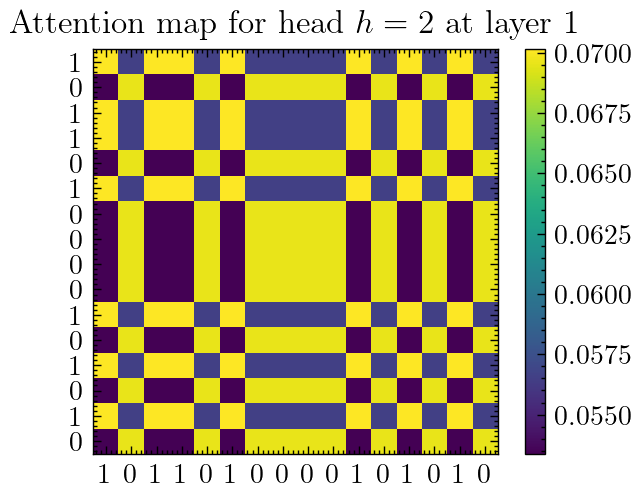

tensor([[0.0130, 0.1010, 0.0130, 0.0130, 0.1010, 0.0130, 0.1010, 0.1010, 0.1010,
         0.1010, 0.0130, 0.1010, 0.0130, 0.1010, 0.0130, 0.1010],
        [0.0165, 0.0983, 0.0165, 0.0165, 0.0983, 0.0165, 0.0983, 0.0983, 0.0983,
         0.0983, 0.0165, 0.0983, 0.0165, 0.0983, 0.0165, 0.0983],
        [0.0130, 0.1010, 0.0130, 0.0130, 0.1010, 0.0130, 0.1010, 0.1010, 0.1010,
         0.1010, 0.0130, 0.1010, 0.0130, 0.1010, 0.0130, 0.1010],
        [0.0130, 0.1010, 0.0130, 0.0130, 0.1010, 0.0130, 0.1010, 0.1010, 0.1010,
         0.1010, 0.0130, 0.1010, 0.0130, 0.1010, 0.0130, 0.1010],
        [0.0165, 0.0983, 0.0165, 0.0165, 0.0983, 0.0165, 0.0983, 0.0983, 0.0983,
         0.0983, 0.0165, 0.0983, 0.0165, 0.0983, 0.0165, 0.0983],
        [0.0130, 0.1010, 0.0130, 0.0130, 0.1010, 0.0130, 0.1010, 0.1010, 0.1010,
         0.1010, 0.0130, 0.1010, 0.0130, 0.1010, 0.0130, 0.1010],
        [0.0165, 0.0983, 0.0165, 0.0165, 0.0983, 0.0165, 0.0983, 0.0983, 0.0983,
         0.0983, 0.0165, 0.0983, 0.01

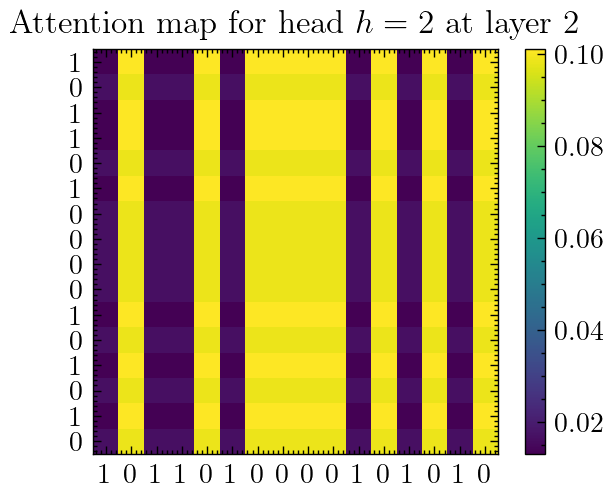

tensor([[0.0565, 0.0672, 0.0565, 0.0565, 0.0672, 0.0565, 0.0672, 0.0672, 0.0672,
         0.0672, 0.0565, 0.0672, 0.0565, 0.0672, 0.0565, 0.0672],
        [0.0583, 0.0658, 0.0583, 0.0583, 0.0658, 0.0583, 0.0658, 0.0658, 0.0658,
         0.0658, 0.0583, 0.0658, 0.0583, 0.0658, 0.0583, 0.0658],
        [0.0565, 0.0672, 0.0565, 0.0565, 0.0672, 0.0565, 0.0672, 0.0672, 0.0672,
         0.0672, 0.0565, 0.0672, 0.0565, 0.0672, 0.0565, 0.0672],
        [0.0565, 0.0672, 0.0565, 0.0565, 0.0672, 0.0565, 0.0672, 0.0672, 0.0672,
         0.0672, 0.0565, 0.0672, 0.0565, 0.0672, 0.0565, 0.0672],
        [0.0583, 0.0658, 0.0583, 0.0583, 0.0658, 0.0583, 0.0658, 0.0658, 0.0658,
         0.0658, 0.0583, 0.0658, 0.0583, 0.0658, 0.0583, 0.0658],
        [0.0565, 0.0672, 0.0565, 0.0565, 0.0672, 0.0565, 0.0672, 0.0672, 0.0672,
         0.0672, 0.0565, 0.0672, 0.0565, 0.0672, 0.0565, 0.0672],
        [0.0583, 0.0658, 0.0583, 0.0583, 0.0658, 0.0583, 0.0658, 0.0658, 0.0658,
         0.0658, 0.0583, 0.0658, 0.05

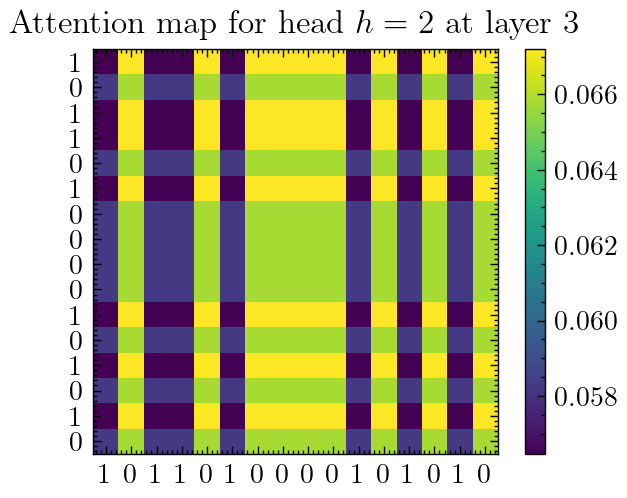

tensor([[0.0816, 0.0476, 0.0816, 0.0816, 0.0476, 0.0816, 0.0476, 0.0476, 0.0476,
         0.0476, 0.0816, 0.0476, 0.0816, 0.0476, 0.0816, 0.0476],
        [0.0769, 0.0513, 0.0769, 0.0769, 0.0513, 0.0769, 0.0513, 0.0513, 0.0513,
         0.0513, 0.0769, 0.0513, 0.0769, 0.0513, 0.0769, 0.0513],
        [0.0816, 0.0476, 0.0816, 0.0816, 0.0476, 0.0816, 0.0476, 0.0476, 0.0476,
         0.0476, 0.0816, 0.0476, 0.0816, 0.0476, 0.0816, 0.0476],
        [0.0816, 0.0476, 0.0816, 0.0816, 0.0476, 0.0816, 0.0476, 0.0476, 0.0476,
         0.0476, 0.0816, 0.0476, 0.0816, 0.0476, 0.0816, 0.0476],
        [0.0769, 0.0513, 0.0769, 0.0769, 0.0513, 0.0769, 0.0513, 0.0513, 0.0513,
         0.0513, 0.0769, 0.0513, 0.0769, 0.0513, 0.0769, 0.0513],
        [0.0816, 0.0476, 0.0816, 0.0816, 0.0476, 0.0816, 0.0476, 0.0476, 0.0476,
         0.0476, 0.0816, 0.0476, 0.0816, 0.0476, 0.0816, 0.0476],
        [0.0769, 0.0513, 0.0769, 0.0769, 0.0513, 0.0769, 0.0513, 0.0513, 0.0513,
         0.0513, 0.0769, 0.0513, 0.07

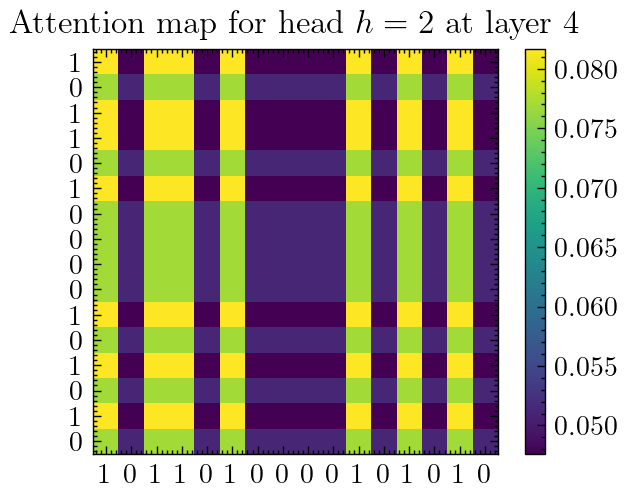

In [96]:
for h in range(nheads):
    for nb_layer, a in enumerate(attn_probs_maps):
        print(a[0,h])
        plt.imshow(a[0,h], cmap='viridis', interpolation='nearest')
        plt.colorbar()
        if seq_len <= 16:
            b = np.array(binary_sequence[0].squeeze())
            plt.xticks(np.arange(seq_len), b)
            plt.yticks(np.arange(seq_len), b)
        plt.title(f'Attention map for head $h={h+1}$ at layer {nb_layer+1}')
        plt.show()